In [3]:
import random
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
import matplotlib.pyplot as plt

In [4]:
random.seed(10)
file_path = './data/cmn.txt'
START_TOKEN = 'SOS'
END_TOKEN = 'EOS'

with open(file_path, 'r') as file:
    total_lines = sum(1 for line in file)

lines_to_read = int(1 * total_lines)

random_lines = random.sample(range(total_lines), lines_to_read)

en = []
cn = []
with open(file_path, 'r') as file:
    for line_number, line in enumerate(file):
        if line_number in random_lines:
            line = line.strip().split('\t')
            en.append(word_tokenize(line[0].lower()))
            cn.append([START_TOKEN] + word_tokenize(" ".join([w for w in line[1]])) + [END_TOKEN])

print(len(en))
print(len(cn))

print(en[201:206])
print(cn[201:206])

18167
18167
[['i', 'love', 'you', '.'], ['i', 'miss', 'you', '.'], ['i', 'need', 'you', '.'], ['i', 'think', 'so', '.'], ['i', 'use', 'this', '.']]
[['SOS', '我', '爱', '您', '。', 'EOS'], ['SOS', '我', '想', '念', '你', '。', 'EOS'], ['SOS', '我', '需', '要', '你', '。', 'EOS'], ['SOS', '我', '想', '是', '這', '樣', '的', '。', 'EOS'], ['SOS', '我', '使', '用', '这', '个', '。', 'EOS']]


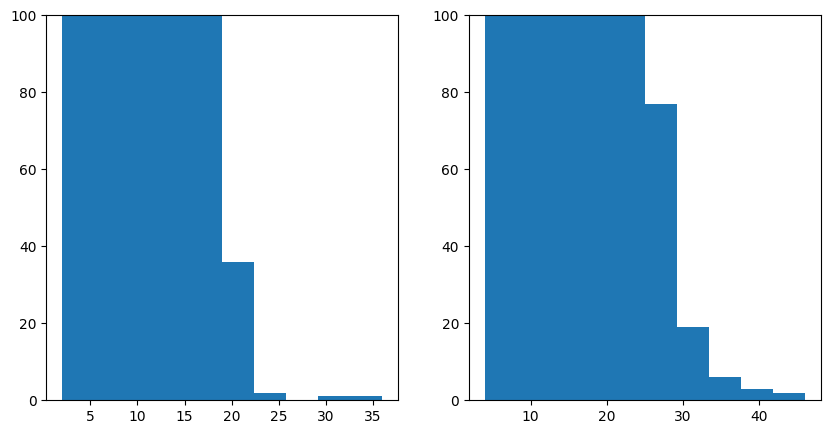

In [8]:
en_len = [len(s) for s in en]
cn_len = [len(s) for s in cn]
f, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].hist(en_len, bins = 10)
axs[0].set(ylim=(0, 100))
axs[1].hist(cn_len, bins = 10)
axs[1].set(ylim=(0, 100))
plt.show()

#### filter sentences by max_sequence_length of 32

In [13]:
max_sequence_length = 32
valid_en = []
valid_cn = []
for i in range(len(en)):
    if len(en[i]) <= max_sequence_length and len(cn[i]) <= max_sequence_length:
        valid_en.append(en[i])
        valid_cn.append(cn[i])

In [14]:
en_all_tokens = []
for en_sentence in valid_en:
    for token in en_sentence:
        en_all_tokens.append(token)

en_token_counts = Counter(en_all_tokens)
en_common_tokens = en_token_counts.most_common(10000)
print(f"number of en tokens {len(en_common_tokens)}")
en_token_dict = {token: index for index, (token, _) in enumerate(en_common_tokens)}
en_token_dict['UNK'] = len(en_common_tokens)
en_token_dict['PAD'] = len(en_common_tokens) + 1

cn_all_tokens = []
for cn_sentence in valid_cn:
    for token in cn_sentence:
        cn_all_tokens.append(token)

cn_token_counts = Counter(cn_all_tokens)
cn_common_tokens = cn_token_counts.most_common(10000)
print(f"number of cn tokens {len(cn_common_tokens)}")
cn_token_dict = {token: index for index, (token, _) in enumerate(cn_common_tokens)}
cn_token_dict['UNK'] = len(cn_common_tokens)
cn_token_dict['PAD'] = len(cn_common_tokens) + 1

number of en tokens 6022
number of cn tokens 3354


In [19]:
en_tokenized = []
for en_sentence in valid_en:
    if len(en_sentence) < max_sequence_length:
        en_sentence = en_sentence + ['PAD'] * (max_sequence_length - len(en_sentence))
    en_tokenized.append(torch.tensor([en_token_dict.get(token, en_token_dict['UNK']) for token in en_sentence]))

cn_tokenized = []
for cn_sentence in valid_cn:
    if len(cn_sentence) < max_sequence_length:
        cn_sentence = cn_sentence + ['PAD'] * (max_sequence_length - len(cn_sentence))
    cn_tokenized.append(torch.tensor([cn_token_dict.get(token, cn_token_dict['UNK']) for token in cn_sentence]))

print(len(en_tokenized))
print(len(cn_tokenized))
print(cn_tokenized[:3])

18153
18153
[tensor([   0, 1771,    2,    1, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355,
        3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355,
        3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355]), tensor([   0,    6,   33,    2,    1, 3355, 3355, 3355, 3355, 3355, 3355, 3355,
        3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355,
        3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355]), tensor([   0,    6,   86,  397,    4,    2,    1, 3355, 3355, 3355, 3355, 3355,
        3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355,
        3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355])]
6023
3355


In [16]:
from torch.utils.data import Dataset, DataLoader, random_split

class TokenizedDataset(Dataset):
    def __init__(self, en_tokenized_sentences, cn_tokenized_sentences):
        self.en_tokenized = en_tokenized_sentences
        self.cn_tokenized = cn_tokenized_sentences
    
    def __len__(self):
        return len(self.en_tokenized)
    
    def __getitem__(self, idx):
        return self.en_tokenized[idx], self.cn_tokenized[idx]

In [22]:
dataset = TokenizedDataset(en_tokenized, cn_tokenized)

# Define the size of your train and test datasets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Split the dataset into train and test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for train and test datasets
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
first_batch = next(iter(train_loader))
print(first_batch)

[tensor([[   1,   49,  383,   60,    0, 6023, 6023, 6023, 6023, 6023, 6023, 6023,
         6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023,
         6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023],
        [   7,   41,  151,   24,    1,   65,   32,  157,    6, 6023, 6023, 6023,
         6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023,
         6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023],
        [   8,  177,    5,  218,  163,    0, 6023, 6023, 6023, 6023, 6023, 6023,
         6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023,
         6023, 6023, 6023, 6023, 6023, 6023, 6023, 6023]]), tensor([[   0,    3,  276,  624,   15,   49,    4,  132,   23,   20,    2,    1,
         3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355,
         3355, 3355, 3355, 3355, 3355, 3355, 3355, 3355],
        [   0,   13,   31,   39,  416,  170,    9,    3,   10,  161,   85,    4,
           46,   62,    1, 3355, 335

In [62]:
def create_masks(eng_batch, cn_batch, eng_pad_token, cn_pad_token):
    # Create masks based on padding tokens
    eng_mask = (eng_batch == eng_pad_token)
    cn_mask = (cn_batch == cn_pad_token)

    # Create Look-Ahead Mask
    max_sequence_length = eng_batch.size(1)  # Assuming both batches have the same sequence length
    look_ahead_mask = torch.triu(torch.ones(max_sequence_length, max_sequence_length), diagonal=1) == 1

    # Expand masks to 3D for self-attention and cross-attention
    encoder_padding_mask = eng_mask.unsqueeze(1).repeat(1, max_sequence_length, 1)
    decoder_padding_mask_self_attention = cn_mask.unsqueeze(1).repeat(1, max_sequence_length, 1)
    decoder_padding_mask_cross_attention = eng_mask.unsqueeze(1).repeat(1, max_sequence_length, 1)

    # Calculate the final masks with some negative infinity value for masked positions
    NEG_INFTY = -1e9
    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask = torch.where(look_ahead_mask.unsqueeze(0) + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)

    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [63]:
eng_pad_token = en_token_dict.get('PAD')
cn_pad_token = cn_token_dict.get('PAD')
# Assuming eng_batch and cn_batch are your input tensors
encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(first_batch[0], first_batch[1], eng_pad_token, cn_pad_token)

In [67]:
print(decoder_cross_attention_mask[0][0])

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09])


In [ ]:
# check if item is Chinese character
# cn_end_marks_filtered = []
# for item in cn_end_marks_set:
#     if not re.search("[\u4e00-\u9FFF]", item):
#         cn_end_marks_filtered.append(item)
# print(cn_end_marks_filtered)

In [71]:
eng_batch = torch.tensor([[23, 7, 5, 1, 1], [15, 25, 2, 6, 1]])
cn_batch = torch. tensor([[6, 8, 1, 1, 1], [19, 5, 3, 1, 1]])
padding_token = 1
eng_mask = (eng_batch == padding_token)
cn_mask = (cn_batch == padding_token)
decoder_padding_mask_self_attention = cn_mask.unsqueeze(1).repeat(1, 5, 1)
print(decoder_padding_mask_self_attention)

tensor([[[False, False,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False,  True,  True,  True]],

        [[False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True]]])


In [73]:
look_ahead_mask = torch.triu(torch.ones(5, 5), diagonal=1) == 1
print(f"look ahead mask:\n {look_ahead_mask}")
decoder_padding_mask_cross_attention = look_ahead_mask.unsqueeze(0) + decoder_padding_mask_self_attention
print(decoder_padding_mask_cross_attention)

look ahead mask:
 tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])
tensor([[[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False,  True,  True,  True]],

        [[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True]]])


In [46]:
decoder_cross_attention_mask = torch.where((decoder_padding_mask_cross_attention), NEG_INFTY, 0)
print(decoder_cross_attention_mask)

tensor([[[ 0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09]],

        [[ 0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09]]])
